# Heart Disease Analysis

Let us start my importing all necessary libraries for this analysis

In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #Seaborn is a very effective package for plotting
from sklearn.ensemble import RandomForestClassifier #Our selection of model for the dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz #export_graphviz is a fantastic way to illustrate the model
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import shap #for SHAP values

import eli5 
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, info_plots #for partial plots

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None  #hide any pandas warnings

The first step in my rational would be to have a look at the data in it's rawest form to see where we can start making changes to create a more robust dataset for analysis.  

In [462]:
dataframe = pd.read_csv('heart.csv')

In [463]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset has some abbreviated terms explaining the contributing factors to heart disease. I will now change the names of these columns to make for a more comprehensive representationof the data.

In [464]:
dataframe.columns = ['Age', 'Sex', 'Chest_pain_experience','Resting_blood_pressure', 'Cholestarol', 'Fasting_blood_sugar', 'Resting_electrocardiographic_measurement',
                      'maximum_heart_rate_achieved', 'Exercise_induced_angina', 'ST_depression_induced_by _exercise', 'slope_of_the_peak_exercise_ST_segment',
                      'The_number_of_major_vessels', 'Thalassemia', 'Heart_disease']

It is desireable to have more of an explaination of the columns to gain better insight of how to go about deducing which factors have the most significant effect on the outcome of heart disease. 

- __age__: The person's age in years
- __sex__: The person's sex (1 = male, 0 = female)
- __cp__: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- __trestbps__: The person's resting blood pressure (mm Hg on admission to the hospital)
- __chol__: The person's cholesterol measurement in mg/dl
- __fbs__: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- __restecg__: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- __thalach__: The person's maximum heart rate achieved
- __exang__: Exercise induced angina (1 = yes; 0 = no)
- __oldpeak__: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
- __slope__: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- __ca__: The number of major vessels (0-3)
- __thal__: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- __target__: Heart disease (0 = no, 1 = yes)

For this anaylsis we will take factors which are controlling into consideration, as these are ultimately what we wish to change in our lives to reduce the probability of heart disease. Any factors of a heredity nature are considered to be unfortunate circumstances. Our focus should be providing information to a user based on factors which may be mitigated to avoid heart disease.

It must be said that these initial factors are assumptions and have been derived from 'Google' knowledge.

Factors considered to me significant, will come out as such when analysising the model at a later stage.

I will now convert the catergorial variables into more descriptive terms. This will come into play a bit later on to improve the interpretation of the model.

In [465]:
dataframe['Sex'][dataframe['Sex'] == 0] = 'female'
dataframe['Sex'][dataframe['Sex'] == 1] = 'male'

dataframe['Chest_pain_experience'][dataframe['Chest_pain_experience'] == 1] = 'typical angina'
dataframe['Chest_pain_experience'][dataframe['Chest_pain_experience'] == 2] = 'atypical angina'
dataframe['Chest_pain_experience'][dataframe['Chest_pain_experience'] == 3] = 'non-anginal pain'
dataframe['Chest_pain_experience'][dataframe['Chest_pain_experience'] == 4] = 'asymptomatic'

dataframe['Fasting_blood_sugar'][dataframe['Fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dataframe['Fasting_blood_sugar'][dataframe['Fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dataframe['Resting_electrocardiographic_measurement'][dataframe['Resting_electrocardiographic_measurement'] == 0] = 'normal'
dataframe['Resting_electrocardiographic_measurement'][dataframe['Resting_electrocardiographic_measurement'] == 1] = 'ST-T wave abnormality'
dataframe['Resting_electrocardiographic_measurement'][dataframe['Resting_electrocardiographic_measurement'] == 2] = 'left ventricular hypertrophy'

dataframe['Exercise_induced_angina'][dataframe['Exercise_induced_angina'] == 0] = 'no'
dataframe['Exercise_induced_angina'][dataframe['Exercise_induced_angina'] == 1] = 'yes'

dataframe['slope_of_the_peak_exercise_ST_segment'][dataframe['slope_of_the_peak_exercise_ST_segment'] == 1] = 'upsloping'
dataframe['slope_of_the_peak_exercise_ST_segment'][dataframe['slope_of_the_peak_exercise_ST_segment'] == 2] = 'flat'
dataframe['slope_of_the_peak_exercise_ST_segment'][dataframe['slope_of_the_peak_exercise_ST_segment'] == 3] = 'downsloping'

dataframe['Thalassemia'][dataframe['Thalassemia'] == 1] = 'normal'
dataframe['Thalassemia'][dataframe['Thalassemia'] == 2] = 'fixed defect'
dataframe['Thalassemia'][dataframe['Thalassemia'] == 3] = 'reversable defect'


In [466]:
dataframe.dtypes

Age                                           int64
Sex                                          object
Chest_pain_experience                        object
Resting_blood_pressure                        int64
Cholestarol                                   int64
Fasting_blood_sugar                          object
Resting_electrocardiographic_measurement     object
maximum_heart_rate_achieved                   int64
Exercise_induced_angina                      object
ST_depression_induced_by _exercise          float64
slope_of_the_peak_exercise_ST_segment        object
The_number_of_major_vessels                   int64
Thalassemia                                  object
Heart_disease                                 int64
dtype: object

It is now of particular interest to convert the object variables back to categorical values. 

In [467]:
dataframe['Sex'] = dataframe['Sex'].astype('object')
dataframe['Chest_pain_experience'] = dataframe['Chest_pain_experience'].astype('object')
dataframe['Fasting_blood_sugar'] = dataframe['Fasting_blood_sugar'].astype('object')
dataframe['Resting_electrocardiographic_measurement'] = dataframe['Resting_electrocardiographic_measurement'].astype('object')
dataframe['Exercise_induced_angina'] = dataframe['Exercise_induced_angina'].astype('object')
dataframe['slope_of_the_peak_exercise_ST_segment'] = dataframe['slope_of_the_peak_exercise_ST_segment'].astype('object')
dataframe['Thalassemia'] = dataframe['Thalassemia'].astype('object')

I will now create dummy variables for the categorical variables. For simplicity's sake I will remove the first category of each, for example drop 'female' and just have 'male' (1 - is male, 0 - not male, hence female).

In [468]:
dataframe = pd.get_dummies(dataframe, drop_first=True)

Let's have look at the data set and see how the above changes have effected the data.

In [469]:
dataframe.head()

,Age,Resting_blood_pressure,Cholestarol,maximum_heart_rate_achieved,ST_depression_induced_by _exercise,The_number_of_major_vessels,Heart_disease,Sex_male,Chest_pain_experience_atypical angina,Chest_pain_experience_non-anginal pain,Chest_pain_experience_typical angina,Fasting_blood_sugar_lower than 120mg/ml,Resting_electrocardiographic_measurement_left ventricular hypertrophy,Resting_electrocardiographic_measurement_normal,Exercise_induced_angina_yes,slope_of_the_peak_exercise_ST_segment_flat,slope_of_the_peak_exercise_ST_segment_upsloping,Thalassemia_fixed defect,Thalassemia_normal,Thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


The data is now ready to be used for the construction of a predictive model. 

# The Model

I will start by fitting the X and y values of the model to the data set and then generate the training set, as well as the test set for a Random Forest Model.

In [470]:
X = dataframe.drop('Heart_disease', 1)
y = dataframe['Heart_disease']

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [472]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [473]:
model2 = LogisticRegression(random_state=0)
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

I will now start utilising the power of the model by making a prediction based on the variables associated with heart disease. 

In [499]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [500]:
y_pred = model.predict(X_test)

In [501]:
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [502]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[28,  7],
       [ 4, 22]])

It is desirable to now gain more insight with regards to the __sensitivity__ and the __specificity__ of the model's performance. 

$Sensitivity\:=\:\frac{True\:Positives}{True\:Positives\:+\:False\:Negatives}$

$Specificity\:=\:\frac{True\:Negatives}{True\:Negatives\:+\:False\:Positive}$


In [503]:
Sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

Specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

print('Sensitivity:', Sensitivity)
print('Specificity:', Specificity)


Sensitivity: 0.875
Specificity: 0.7586206896551724


This looks promising, for a better grasp of the performance of the model let us evaluate the __Reciever Operator Curve (ROC)__

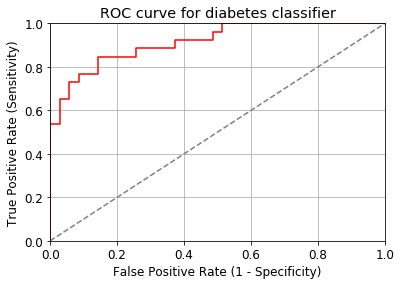

In [504]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate, color = 'red')
ax.plot([0, 1], [0, 1], transform=ax.transAxes,ls="--", c='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the Area Under the Curve, or AUC. This allows us to capture the performance of the model. The metric is useful but is by no means the definitive measure of model performance.
We assume the following as a guideline when assessing AUC,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

Let's see what AUC we obtain from our model.

In [505]:
auc(false_positive_rate,true_positive_rate)

0.9153846153846154

This looks promising. Let's move on and start using some more elaborate explanatory tools. 

I will now perfom the same proceedure for a Logistic regression model to explore different machine learning algorithms applicable to the dataset. 

In [506]:
from sklearn.metrics import confusion_matrix

In [507]:
y_pred2 = model2.predict(X_test)

In [508]:
y_pred_quant2 = model2.predict_proba(X_test)[:, 1]
y_pred_bin2 = model2.predict(X_test)

In [509]:
confusion_matrix2 = confusion_matrix(y_test, y_pred2)
confusion_matrix2

array([[29,  6],
       [ 6, 20]])

In [510]:
Sensitivity2 = confusion_matrix2[0,0]/(confusion_matrix2[0,0]+confusion_matrix2[1,0])

Specificity2 = confusion_matrix2[1,1]/(confusion_matrix2[1,1]+confusion_matrix2[0,1])

print('Sensitivity:', Sensitivity2)
print('Specificity:', Specificity2)


Sensitivity: 0.8285714285714286
Specificity: 0.7692307692307693


Logistic regression might obtain a higher specificity value, but has a lower sensitivity value. What does this mean for us, well it essential comes down to what you wish to get out of the problem to deduced with algorithm has performed better. 

I want to see what can be observed when analysing the AUC of the ROC for logistic regression. 

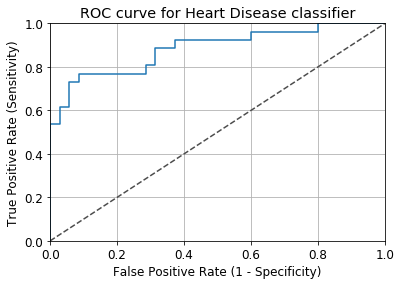

In [511]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_quant2)

fig, ax = plt.subplots()
ax.plot(fpr2, tpr2)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Heart Disease classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [512]:
auc(fpr2,tpr2)

0.8846153846153847

When comparing the AUC the Random forest classifier seems to perform better, albeit by a marginal degree. 

# Explanation

Permutation importance shows us the relative weights applicable to the various variables used by the model to make predictions. It is a very useful tool when deriving value from the dataset itself and identifying areas which carry the most weight in the model. 

This ultimately provides a more comprehensive indications of the effect which the associated varibales have on the accuracy of the model's prediction.

In [513]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0328 ± 0.0415,The_number_of_major_vessels
0.0262 ± 0.0445,Thalassemia_fixed defect
0.0262 ± 0.0445,slope_of_the_peak_exercise_ST_segment_upsloping
0.0262 ± 0.0262,Sex_male
0.0197 ± 0.0131,Chest_pain_experience_atypical angina
0.0164 ± 0.0207,Age
0.0131 ± 0.0382,Exercise_induced_angina_yes
0.0098 ± 0.0262,ST_depression_induced_by _exercise
0.0000 ± 0.0207,Cholestarol
0.0000 ± 0.0359,maximum_heart_rate_achieved


It is clear when analysing the Permutation Importance that Thalassemia, specifically 'Fixed defect' has the greatest effect on the outcome of heart disease. It must be said that the permutation importance, specificially for smaller datasets with vary from model prediction to model prediction. For example if all the code used to run the model was run with a refreshed kernel, the permutation importance could have a very different result. 

Let us assess the Partial dependency plot for the number of major blood vessels, which according to the permuation importance, would not result in a severe change in the result due to reshuffling of the column. 

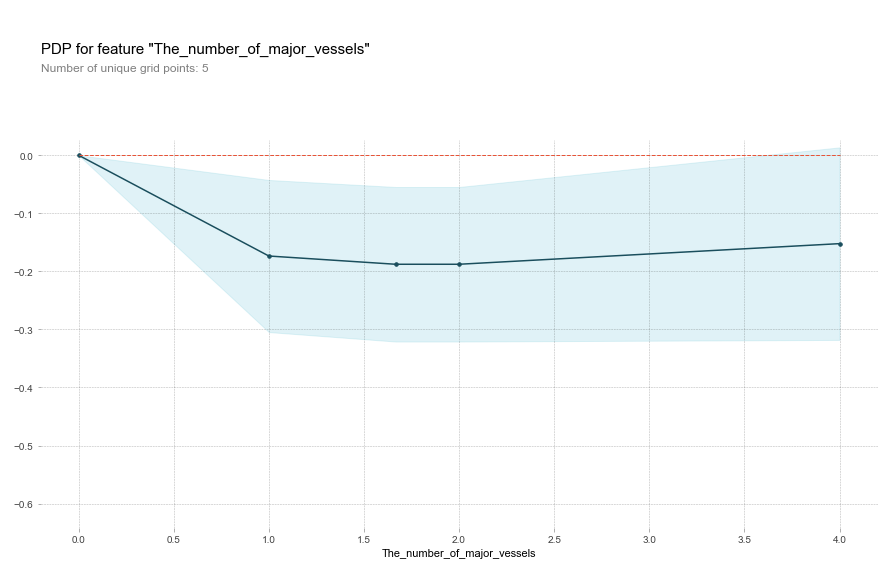

In [514]:
base_features = dataframe.columns.values.tolist()
base_features.remove('Heart_disease')

feat_name = 'The_number_of_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Although the permutation importance suggest that there is not a significant effect on the prediction, this pdp tells a different story. The pdp shows that with an increase in the number of blood vessels there is a clear reduction in the probability of suffering from heart disease. 

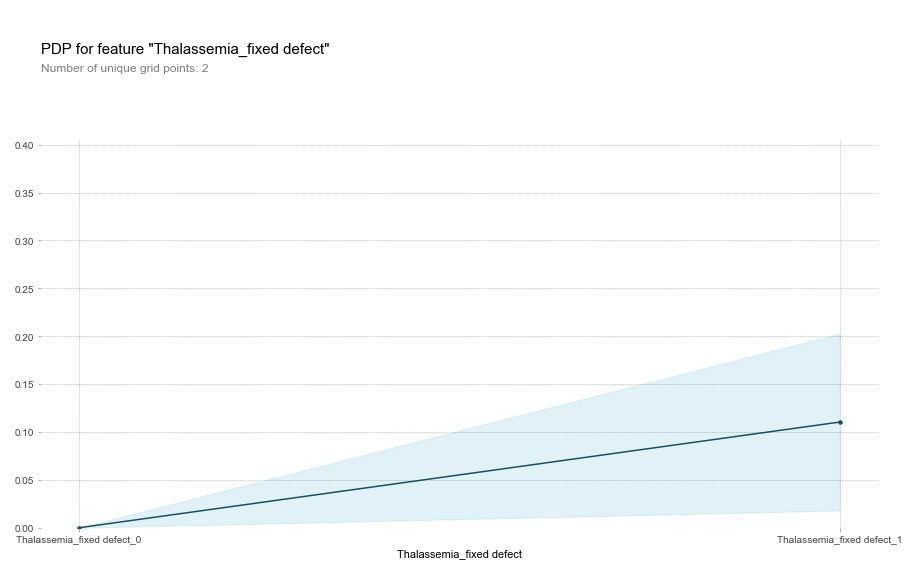

In [515]:
base_features = dataframe.columns.values.tolist()
base_features.remove('Heart_disease')

feat_name = 'Thalassemia_fixed defect'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

It is clear to see from the pdp that having fixed defect Thalassemia increasing the probability of heart disease. I would like to make this analysis slightly more intuitive by having a closer look at the SHAP values associate with the variables.

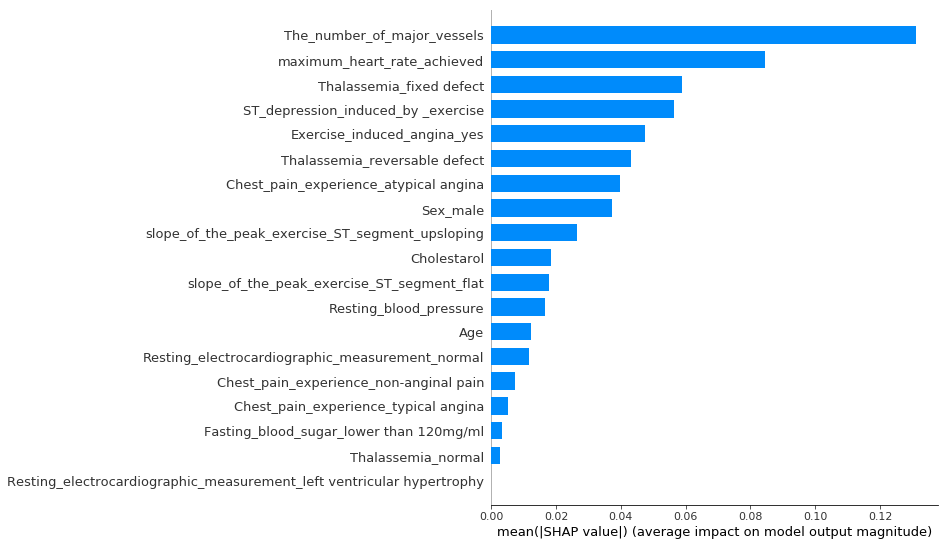

In [517]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

These results seem to coincide more with that of the 'Googling' approach of finding factors associated with heart disease. I would for example trust that __number of major blood vessels__ would play a vital role considering more blood vessels result in more blood is pumped to the heart hence playing in ones favour against heart disease. This is an assumption from my part. 

__Maximum heart achieved__ is a more favourable variable to use when predicting the presents of heart disease as it is not as general as __age__. 

I would like to have a more detailed summary of the actual effect associated with variables in both the outcome of heart disease and the outcome of no heart disease.

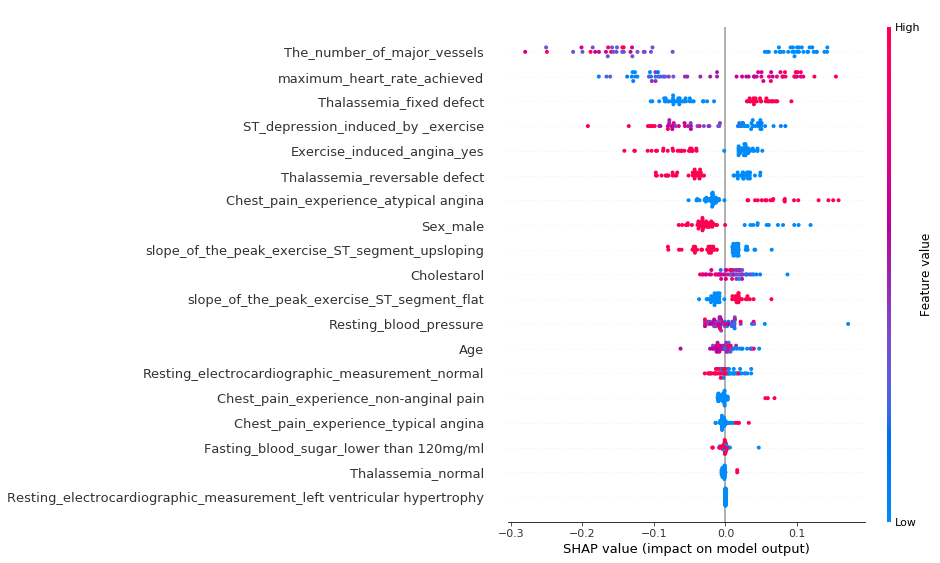

In [518]:
shap.summary_plot(shap_values[1], X_test)

This provides me with a greater insight. For example, plots to the right are considered to increase the probability of heart disease, whilst plots to the left decrease the probability of heart disease. 

It is interesting to note that being male results in a reduced probabilty of heart disease, where again the 'Googling' approach tells us otherwise, that being male increases one's chances of having heart disease. 

By this stage I feel a lot of information has been uncovered from this dataset. It is a basic analysis but is a great indication of the power of using intuition to make assumptions, uncover details and finally bringing light to aspects of the dataset which can provide value to a prospective client. I have personally learnt a lot, not just from machine learning principles, but have also gained some insights into the factors at play when predicting whether a patient has heart disease or not.

I have thoroughly enjoyed working through this dataset and look forward to the next challenge.